# Classify

Classification is a methodology that tries to match a text to the correct label. 

### Prompt based classification 

Prompt based classification is a methodology that relies purely on prompting the LLM in a specific way. 

### When should you use prompt based classification 

Some situations when you would use this methodology is when:
- The labels are easily understood (they don't require explanation or examples)
    
    An example is sentiment analysis
- The labels are not recognized by their semantic meaning
    
    E.g. Reasoning tasks like classifying contradictions
- You don't have many examples

### Example snippet 
Running the following code will instantiate a prompt based classifier, with a debug level for the log. 
Then it will classify the text given in "ClassifyInput".
The contents of the debuglog will be shown below.
The debuglog gives an overview of the steps taken to get the result.

In [87]:
from os import getenv
from aleph_alpha_client import Client
from intelligence_layer.classify import SingleLabelClassify, ClassifyInput
from pprint import pprint

text_to_classify = "Beneath a canopy of stars, aliens of all kinds danced and laughed, celebrating unity in the cosmic night.\n\
The asteroid throbbed with their energy, an unforgettable space party at the heart of the galaxy."
labels = ["Space party", "Space exploration", "Something else", "Something very different and long"]
client = Client(getenv("AA_API_TOKEN"))
task = SingleLabelClassify(client, "info")
input = ClassifyInput(
    text=text_to_classify, 
    labels=labels
)

output = task.run(input)
pprint(output.debug_log.model_dump())
pprint(output.scores)

[{'level': 'info',
  'message': 'Tokenized Labels',
  'value': {'Something else': [{'token': 'ĠSomething', 'token_id': 55978},
                               {'token': 'Ġelse', 'token_id': 7372},
                               {'token': '<|endoftext|>', 'token_id': 0}],
            'Something very different and long': [{'token': 'ĠSomething',
                                                   'token_id': 55978},
                                                  {'token': 'Ġvery',
                                                   'token_id': 2187},
                                                  {'token': 'Ġdifferent',
                                                   'token_id': 2972},
                                                  {'token': 'Ġand',
                                                   'token_id': 348},
                                                  {'token': 'Ġlong',
                                                   'token_id': 1964},
                         

### How does this implemetation work
For prompt based classification, we prompt the model multiple times with the text we want to classify and each of our classes. 
Instead of letting the model generate the class it thinks fits the text best, we ask it for the probability for each class.

To further explain this, lets start with a more familiar case.
The intuitive way to ask an LLM if it could label a text could be something like this: 

In [88]:
from aleph_alpha_client import PromptTemplate

prompt_template = PromptTemplate(SingleLabelClassify.PROMPT_TEMPLATE) 
print(prompt_template.to_prompt(text=text_to_classify, label="").items[0].text)

### Instruction:
Identify a class that describes the text adequately.
Reply with only the class label.

### Input:
Beneath a canopy of stars, aliens of all kinds danced and laughed, celebrating unity in the cosmic night.
The asteroid throbbed with their energy, an unforgettable space party at the heart of the galaxy.

### Response:


The model would then answer our question, and give us a class that it thinks fits the text. 

In the case of classification, however, we already have the classes beforehand.
Because of this, all we are interested in is the probability the model would have guessed our specific classes.
To get this probability, we can prompt the model with each of our classes and ask the model to return the logprobs for the text. 

In case of prompt based classification the prompt looks something like this:

In [89]:
prompt_template = PromptTemplate(SingleLabelClassify.PROMPT_TEMPLATE) 
print(prompt_template.to_prompt(text=text_to_classify, label=labels[0]).items[0].text)

### Instruction:
Identify a class that describes the text adequately.
Reply with only the class label.

### Input:
Beneath a canopy of stars, aliens of all kinds danced and laughed, celebrating unity in the cosmic night.
The asteroid throbbed with their energy, an unforgettable space party at the heart of the galaxy.

### Response:Space party


As you can see, we have pre-emptively filled in the class in our prompt.

Our request will now not generate any tokens, but instead will just return us the logprobs that the class would be generated, given the previous tokens.

In [90]:
??SingleLabelClassify._complete

Signature:
SingleLabelClassify._complete(
    self,
    model: str,
    prompt_template: aleph_alpha_client.prompt_template.PromptTemplate,
    debug_log: intelligence_layer.task.DebugLog,
    **kwargs: Any,
) -> intelligence_layer.completion.CompletionOutput
Docstring: <no docstring>
Source:   
    def _complete(
        self,
        model: str,
        prompt_template: PromptTemplate,
        debug_log: DebugLog,
        **kwargs: Any
    ) -> CompletionOutput:
        request = CompletionRequest(
            prompt=prompt_template.to_prompt(**kwargs),
            maximum_tokens=0,
            log_probs=0,
            tokens=True,
            echo=True,
        )
        return self.completion_task.run(CompletionInput(request=request, model=model))
File:      ~/repos/intelligence-layer/src/intelligence_layer/classify.py
Type:      function

In the case of the classes "Space exploration" and "Space party", the logprobs per label might look something like the code snippet below. 

In [91]:
result_objects = [log_entry for log_entry in output.debug_log.root if log_entry.message == "Raw log probs per label"]
pprint(result_objects)

[LogEntry(message='Raw log probs per label', level='info', value={'Space exploration': [TokenWithProb(token=Token(token='ĠSpace', token_id=20928), prob=-5.2103057), TokenWithProb(token=Token(token='Ġexploration', token_id=42347), prob=-17.067636), TokenWithProb(token=Token(token='<|endoftext|>', token_id=0), prob=-0.23751935)], 'Something else': [TokenWithProb(token=Token(token='ĠSomething', token_id=55978), prob=-13.960306), TokenWithProb(token=Token(token='Ġelse', token_id=7372), prob=-9.6932125), TokenWithProb(token=Token(token='<|endoftext|>', token_id=0), prob=-0.00432627)], 'Space party': [TokenWithProb(token=Token(token='ĠSpace', token_id=20928), prob=-5.2103057), TokenWithProb(token=Token(token='Ġparty', token_id=8735), prob=-5.880137), TokenWithProb(token=Token(token='<|endoftext|>', token_id=0), prob=-0.0072391825)], 'Something very different and long': [TokenWithProb(token=Token(token='ĠSomething', token_id=55978), prob=-13.972682), TokenWithProb(token=Token(token='Ġvery', t

Now that we have the logprobs, we just need to do some calculations to turn them into our end score. 

To turn the logprobs into our end scores, first we normalize our probabilities. This will result in the following data structure:

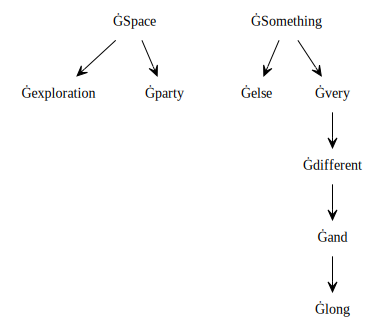

In [99]:
import graphviz  
from IPython import display
import uuid



normalized_probs_logs = [log_entry.value for log_entry in output.debug_log.root if log_entry.message == "Normalized Probs"]
log = normalized_probs_logs.pop()

root = TreeNode()
for probs in log.values():
    root.insert_path(probs)

def graph_path(graph, node: TreeNode):
    for child in node.children:
        if child.token.token == "<|endoftext|>":
            return
        graph.node(UUi)
        graph.edge(node.token.token, child.token.token)
        graph_path(graph, child) 

def graph_nodes(root: TreeNode):
    graph = graphviz.Digraph('normalized probabilities', node_attr={'shape': 'plaintext'})
    graph.graph_attr['rankdir'] = 'TB'  
    graph.edge_attr.update(arrowhead='vee', arrowsize='1')
    for child in root.children:
        graph_path(graph, child)
    return graph 

graph = graph_nodes(root)
display.display_svg(graph)

Finally, we take the product of all the paths to get the following results:

In [93]:
pprint(output.scores)

{'Something else': 0.00011302553813768136,
 'Something very different and long': 4.5410633441516715e-05,
 'Space exploration': 1.3843824699424742e-05,
 'Space party': 0.9998277200037212}
